In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import pickle


%matplotlib inline

In [16]:
fs_dropouts = pd.read_csv('data/9th_grade_dropouts.csv', index_col='sid')

In [17]:
fs_dropouts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52932 entries, 2 to 111990
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dropout           52932 non-null  int64  
 1   male              52932 non-null  float64
 2   math_ss           52932 non-null  float64
 3   read_ss           52932 non-null  float64
 4   gifted            52932 non-null  int64  
 5   ever_alternative  52932 non-null  int64  
 6   iep               52932 non-null  int64  
 7   pct_days_absent   52932 non-null  float64
 8   gpa               52932 non-null  float64
 9   frpl              52932 non-null  float64
 10  ell               52932 non-null  int64  
 11  race_num          52932 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 5.2 MB


OK, let's train/test/split our data

In [18]:
X = fs_dropouts.copy()

In [19]:
y = X.pop('dropout')
y

sid
2         0
5         0
12        1
13        0
14        0
         ..
111984    0
111985    0
111986    0
111988    1
111990    0
Name: dropout, Length: 52932, dtype: int64

In [20]:
X

,male,math_ss,read_ss,gifted,ever_alternative,iep,pct_days_absent,gpa,frpl,ell,race_num
sid,,,,,,,,,,,
2,0.0,-1.0,-1.0,0,1,0,10.664031,1.230000,1.0,0,0
5,0.0,18.0,46.0,0,0,0,0.969005,2.822795,1.0,0,0
12,0.0,18.0,35.0,0,1,0,4.746706,0.330000,0.0,0,0
13,0.0,48.0,80.0,0,0,1,6.850071,2.985000,1.0,0,0
14,1.0,18.0,30.0,0,0,0,5.802631,2.118500,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
111984,1.0,34.0,44.0,0,1,1,9.833898,2.079800,1.0,0,1
111985,0.0,23.0,51.0,1,1,0,2.291429,3.443500,0.0,0,0
111986,1.0,4.0,18.0,0,0,1,7.766962,1.695142,1.0,0,0


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [23]:
rf = RandomForestClassifier(n_estimators = 5000)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000)

In [24]:
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.8564231738035264

In [25]:
cm_rf = confusion_matrix(y_test,y_pred)
cm_rf

array([[12240,   613],
       [ 1667,  1360]])

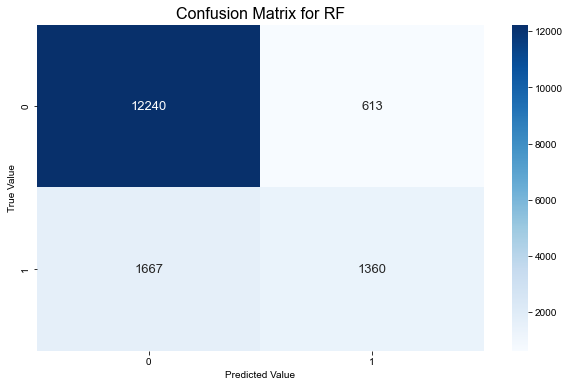

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF', fontsize = 16)
plt.savefig('confusion-matrix-random-forest.png')

In [27]:
score = classification_report(y_test,y_pred, target_names = ['Not Dropout', 'Dropout'])
print(score)

              precision    recall  f1-score   support

 Not Dropout       0.88      0.95      0.91     12853
     Dropout       0.69      0.45      0.54      3027

    accuracy                           0.86     15880
   macro avg       0.78      0.70      0.73     15880
weighted avg       0.84      0.86      0.84     15880



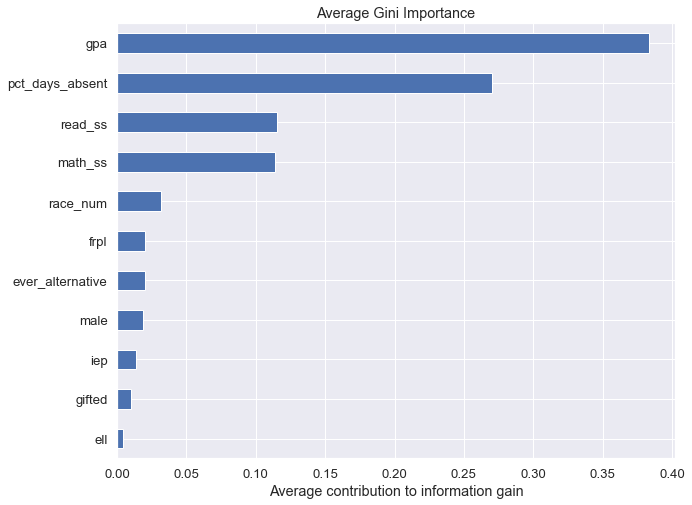

In [28]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

This is not the best...Let's see if we can improve it. I want my dropout precision to be better! 

In [30]:
#Because class is imbalanced, let's try doing some minority class oversampling
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_os, y_os = os.fit_sample(X_train, y_train)
print("length of oversampled data is ",len(X_os))
print("number of negative case in oversampled data",len(y_os == 0))
print("Proportion of no subscription data in oversampled data is ",len(y_os==0)/len(X_os))

length of oversampled data is  60388
number of negative case in oversampled data 60388
Proportion of no subscription data in oversampled data is  1.0


In [31]:
X_os.shape

(60388, 11)

In [32]:
X_train.shape

(37052, 11)

In [34]:
rf.fit(X_os,y_os)
y_pred_os = rf.predict(X_test)
rf.score(X_test,y_test)



0.8295340050377834

In [35]:
cm_rf = confusion_matrix(y_test,y_pred_os)
cm_rf

array([[11413,  1440],
       [ 1267,  1760]])

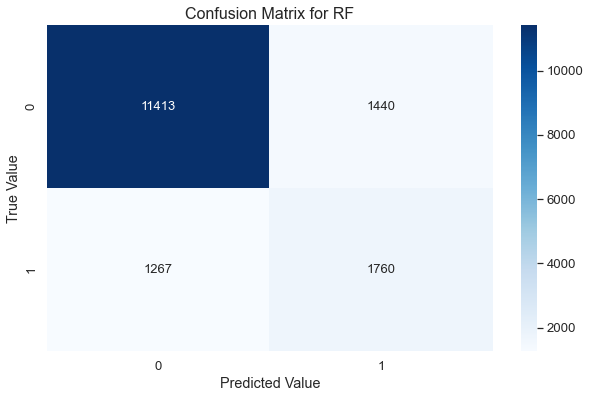

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF', fontsize = 16)
plt.savefig('confusion-matrix-random-forest-with-SMOTE.png')

In [37]:
os_score = classification_report(y_test,y_pred_os, target_names = ['Not Dropout', 'Dropout'])
print(os_score)

              precision    recall  f1-score   support

 Not Dropout       0.90      0.89      0.89     12853
     Dropout       0.55      0.58      0.57      3027

    accuracy                           0.83     15880
   macro avg       0.73      0.73      0.73     15880
weighted avg       0.83      0.83      0.83     15880



Let's do some more feature engineering...Let's drop the last three cols

In [43]:
lowest_features = feat_scores.index[:3]

In [46]:
X_new = X.drop(lowest_features, axis=1)

In [47]:
X

,male,math_ss,read_ss,gifted,ever_alternative,iep,pct_days_absent,gpa,frpl,ell,race_num
sid,,,,,,,,,,,
2,0.0,-1.0,-1.0,0,1,0,10.664031,1.230000,1.0,0,0
5,0.0,18.0,46.0,0,0,0,0.969005,2.822795,1.0,0,0
12,0.0,18.0,35.0,0,1,0,4.746706,0.330000,0.0,0,0
13,0.0,48.0,80.0,0,0,1,6.850071,2.985000,1.0,0,0
14,1.0,18.0,30.0,0,0,0,5.802631,2.118500,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
111984,1.0,34.0,44.0,0,1,1,9.833898,2.079800,1.0,0,1
111985,0.0,23.0,51.0,1,1,0,2.291429,3.443500,0.0,0,0
111986,1.0,4.0,18.0,0,0,1,7.766962,1.695142,1.0,0,0


In [48]:
X_new

,male,math_ss,read_ss,ever_alternative,pct_days_absent,gpa,frpl,race_num
sid,,,,,,,,
2,0.0,-1.0,-1.0,1,10.664031,1.230000,1.0,0
5,0.0,18.0,46.0,0,0.969005,2.822795,1.0,0
12,0.0,18.0,35.0,1,4.746706,0.330000,0.0,0
13,0.0,48.0,80.0,0,6.850071,2.985000,1.0,0
14,1.0,18.0,30.0,0,5.802631,2.118500,1.0,0
...,...,...,...,...,...,...,...,...
111984,1.0,34.0,44.0,1,9.833898,2.079800,1.0,1
111985,0.0,23.0,51.0,1,2.291429,3.443500,0.0,0
111986,1.0,4.0,18.0,0,7.766962,1.695142,1.0,0


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=0)

In [50]:
rf = RandomForestClassifier(n_estimators = 5000)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000)

In [51]:
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.8534005037783375

In [52]:
cm_rf = confusion_matrix(y_test,y_pred)
cm_rf

array([[12212,   641],
       [ 1687,  1340]])

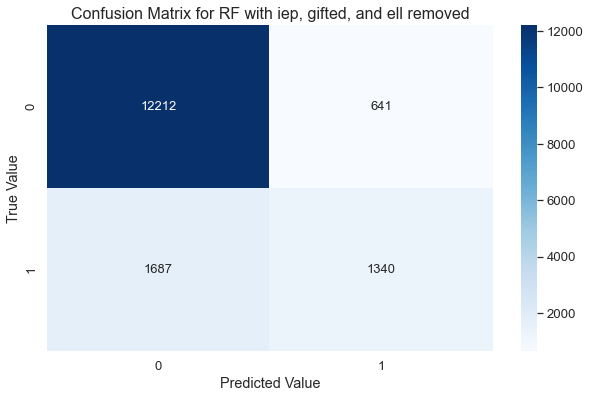

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF with iep, gifted, and ell removed', fontsize = 16)
plt.savefig('confusion-matrix-random-forest-removed-features.png')

In [55]:
new_score = classification_report(y_test,y_pred, target_names = ['Not Dropout', 'Dropout'])
print(new_score)

              precision    recall  f1-score   support

 Not Dropout       0.88      0.95      0.91     12853
     Dropout       0.68      0.44      0.54      3027

    accuracy                           0.85     15880
   macro avg       0.78      0.70      0.72     15880
weighted avg       0.84      0.85      0.84     15880



In [56]:
X

,male,math_ss,read_ss,gifted,ever_alternative,iep,pct_days_absent,gpa,frpl,ell,race_num
sid,,,,,,,,,,,
2,0.0,-1.0,-1.0,0,1,0,10.664031,1.230000,1.0,0,0
5,0.0,18.0,46.0,0,0,0,0.969005,2.822795,1.0,0,0
12,0.0,18.0,35.0,0,1,0,4.746706,0.330000,0.0,0,0
13,0.0,48.0,80.0,0,0,1,6.850071,2.985000,1.0,0,0
14,1.0,18.0,30.0,0,0,0,5.802631,2.118500,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
111984,1.0,34.0,44.0,0,1,1,9.833898,2.079800,1.0,0,1
111985,0.0,23.0,51.0,1,1,0,2.291429,3.443500,0.0,0,0
111986,1.0,4.0,18.0,0,0,1,7.766962,1.695142,1.0,0,0
